In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
train_dir = r"C:\Users\lavan\Downloads\dataset\train"
val_dir = r"C:\Users\lavan\Downloads\dataset\Validation"
test_dir = r"C:\Users\lavan\Downloads\dataset\test"

IMG_SIZE = (128, 128)
BATCH_SIZE = 32


In [6]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, 
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data Loaders
train_data = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE,
                                               batch_size=BATCH_SIZE, class_mode='binary')

val_data = val_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE,
                                           batch_size=BATCH_SIZE, class_mode='binary')

test_data = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)


Found 2800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


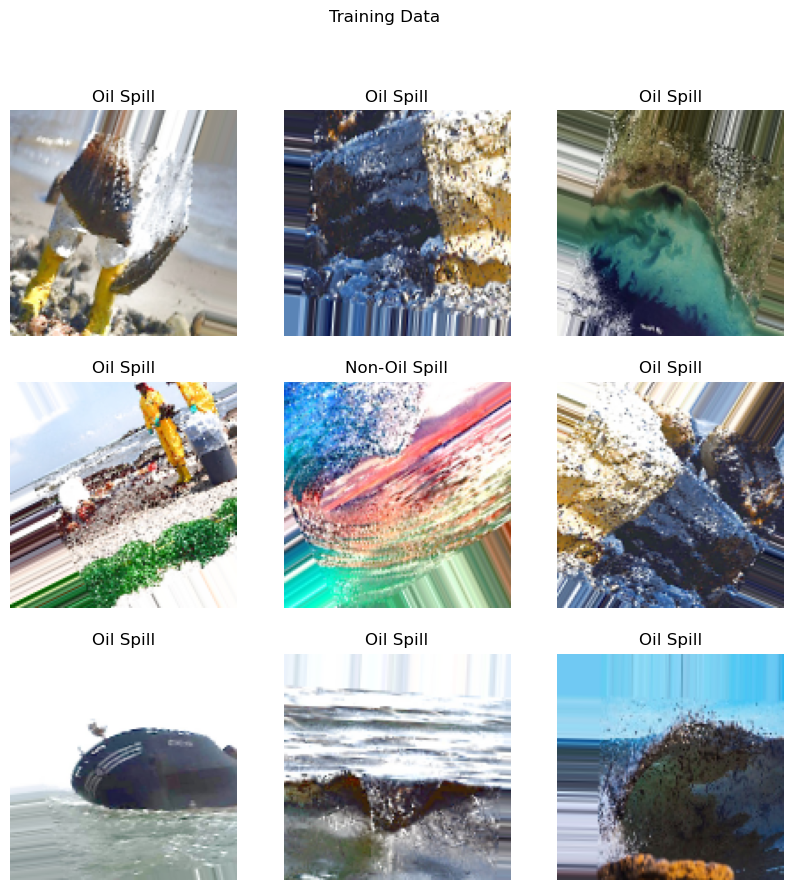

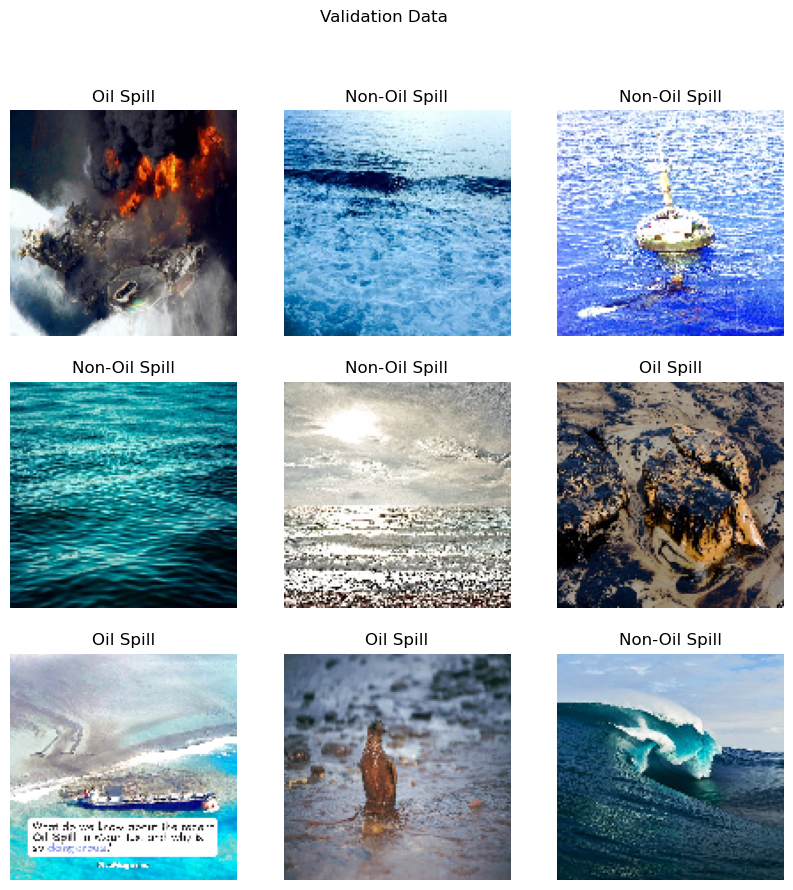

In [8]:
# Visualize sample images
def plot_images(data_gen, title):
    images, labels = next(data_gen)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title("Oil Spill" if labels[i] else "Non-Oil Spill")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_images(train_data, "Training Data")
plot_images(val_data, "Validation Data")


In [20]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(train_data, validation_data=val_data, epochs=40, callbacks=[early_stop, reduce_lr])


Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.5565 - loss: 0.6881 - val_accuracy: 0.6800 - val_loss: 0.6279 - learning_rate: 1.0000e-04
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 960ms/step - accuracy: 0.6862 - loss: 0.6193 - val_accuracy: 0.6733 - val_loss: 0.6122 - learning_rate: 1.0000e-04
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 814ms/step - accuracy: 0.6953 - loss: 0.5901 - val_accuracy: 0.7183 - val_loss: 0.5700 - learning_rate: 1.0000e-04
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 856ms/step - accuracy: 0.7078 - loss: 0.5606 - val_accuracy: 0.7317 - val_loss: 0.5602 - learning_rate: 1.0000e-04
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 68s 773ms/step - accuracy: 0.7491 - loss: 0.5123 - val_accuracy: 0.7300 - val_loss: 0.5308 - learning_rate: 1.0000e-04
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 779ms/step - accuracy: 0.7501 - loss: 0.5058 - val_accuracy: 0.7383 - val_loss: 0.5213 - learning_rate: 1.0000e-04
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 64s 724ms/step - accura

Model saved as oil_spill_classifier.h5


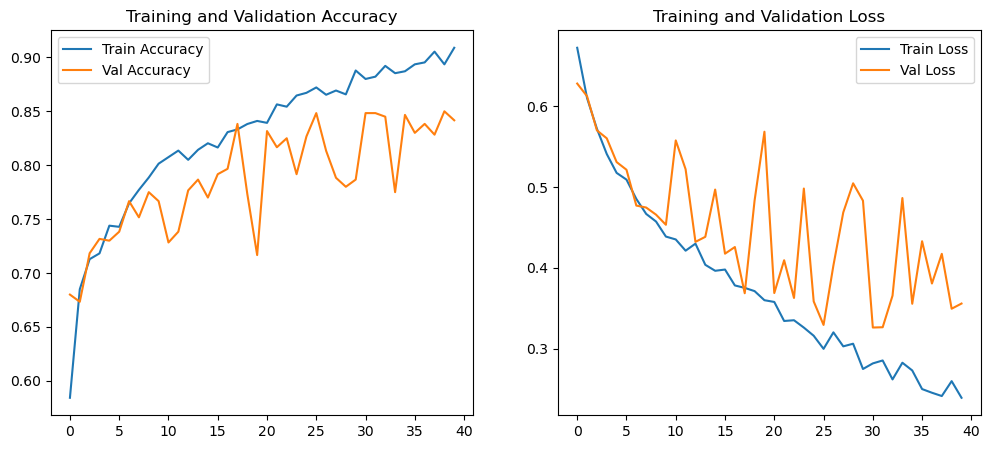

In [24]:
model.save('newoil_spill_classifier_new.h5')
print("Model saved as oil_spill_classifier.h5")
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [26]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc*100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9122 - loss: 0.2271
Test Accuracy: 89.17%


19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 951ms/step
               precision    recall  f1-score   support

Non-Oil Spill       0.86      0.93      0.90       300
    Oil Spill       0.92      0.85      0.89       300

     accuracy                           0.89       600
    macro avg       0.89      0.89      0.89       600
 weighted avg       0.89      0.89      0.89       600



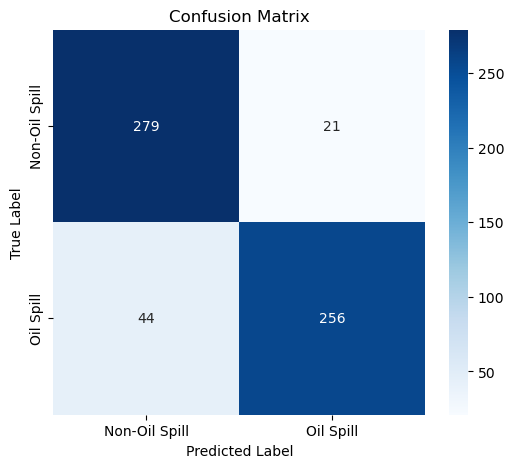

In [28]:
y_pred = (model.predict(test_data) > 0.5).astype("int32")
y_true = test_data.classes

print(classification_report(y_true, y_pred, target_names=['Non-Oil Spill', 'Oil Spill']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Non-Oil Spill', 'Oil Spill'], 
            yticklabels=['Non-Oil Spill', 'Oil Spill'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


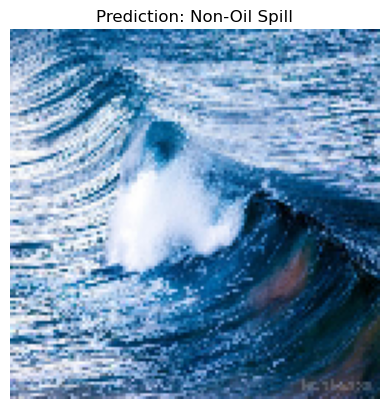

In [30]:
def predict_single_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    label = "Oil Spill" if prediction > 0.5 else "Non-Oil Spill"
    plt.imshow(img)
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()

# Example
predict_single_image(r"C:\Users\lavan\Downloads\dataset\test\Non Oil Spill\No_Oil_Spill00914.jpg")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


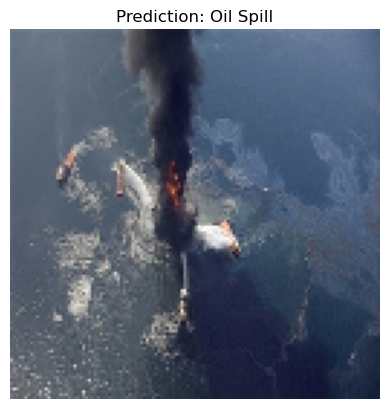

In [32]:
predict_single_image(r"C:\Users\lavan\Downloads\dataset\test\Oil Spill\OilSpill_00811.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


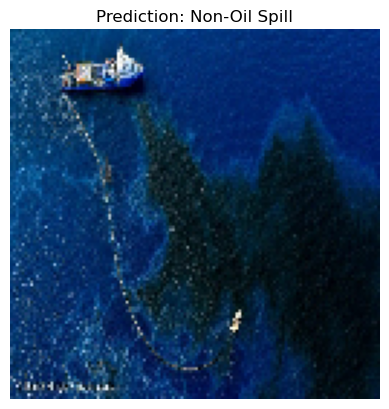

In [34]:
predict_single_image(r"C:\Users\lavan\Downloads\dataset\test\Oil Spill\OilSpill_00826.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


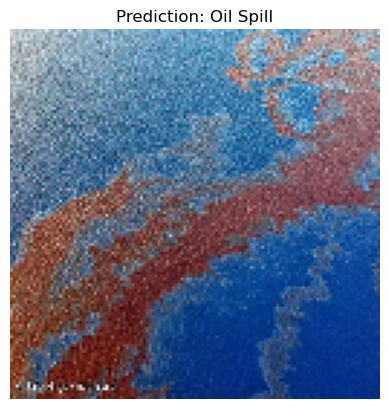

In [36]:
predict_single_image(r"C:\Users\lavan\Downloads\dataset\test\Oil Spill\OilSpill_00843.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


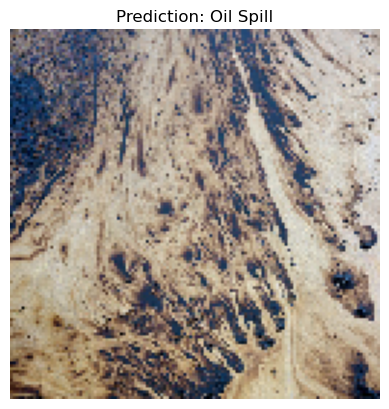

In [38]:
predict_single_image(r"C:\Users\lavan\Downloads\dataset\test\Oil Spill\OilSpill_00836.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


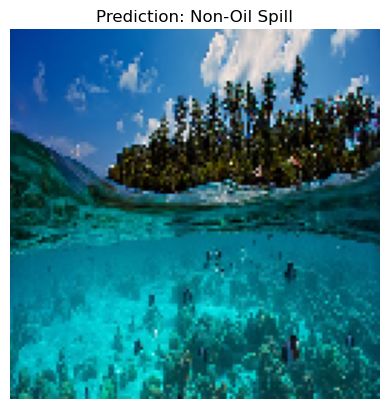

In [40]:
predict_single_image(r"C:\Users\lavan\Downloads\dataset\test\Non Oil Spill\No_Oil_Spill00873.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


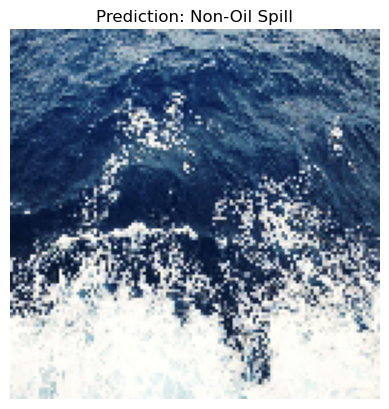

In [42]:
predict_single_image(r"C:\Users\lavan\Downloads\dataset\test\Non Oil Spill\No_Oil_Spill00917.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


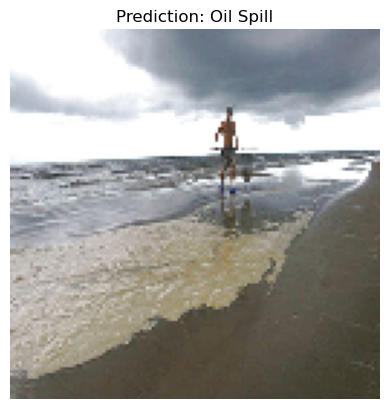

In [44]:
predict_single_image(r"C:\Users\lavan\Downloads\dataset\test\Oil Spill\AUG_oil_spill00268.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


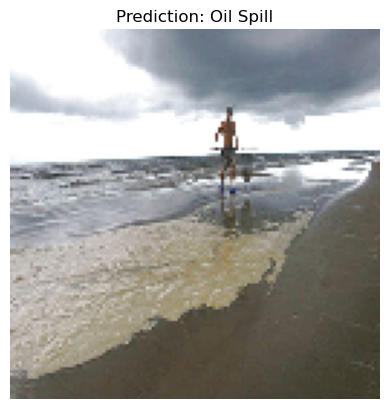

In [46]:
predict_single_image(r"C:\Users\lavan\Downloads\dataset\test\Oil Spill\AUG_oil_spill00268.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


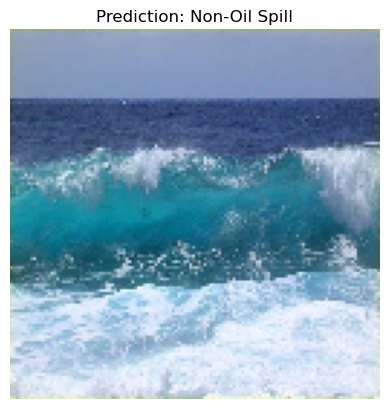

In [48]:
predict_single_image(r"C:\Users\lavan\Downloads\dataset\test\Non Oil Spill\No_Oil_Spill00780.jpg")

Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Result saved to prediction_results.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Result saved to prediction_results.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Result saved to prediction_results.csv


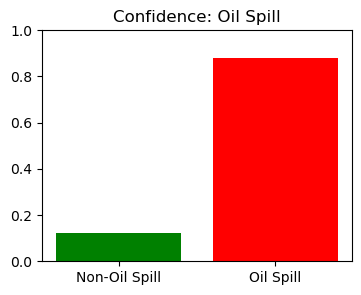

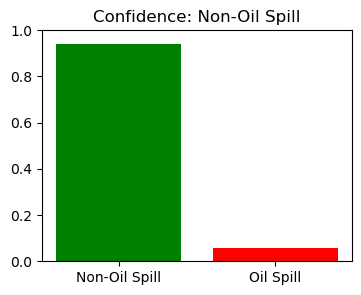

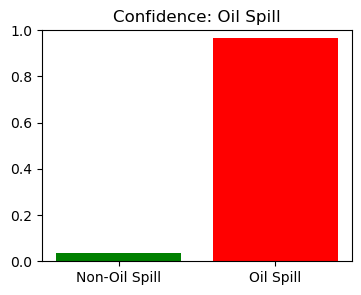

In [2]:
import tkinter as tk
from tkinter import filedialog, Label, Button
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd
import os

# Load the trained model
try:
    model = load_model('newoil_spill_classifier_new.h5')
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

# Set image size (Ensure it matches your model's input size)
IMG_SIZE = (128, 128)

# Function to plot prediction confidence
def plot_prediction(confidence, label):
    labels = ['Non-Oil Spill', 'Oil Spill']
    
    # Correct values based on prediction label
    if label == "Oil Spill":
        values = [1 - confidence, confidence]
    else:
        values = [confidence, 1 - confidence]

    # Clear previous plot
    for widget in plot_frame.winfo_children():
        widget.destroy()

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.bar(labels, values, color=['green', 'red'])
    ax.set_ylim(0, 1)
    ax.set_title(f"Confidence: {label}")
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas.draw()
    canvas.get_tk_widget().pack()

# Function to save results to CSV
def save_result(image_path, label, confidence):
    data = {"Image Path": [image_path], "Prediction": [label], "Confidence": [confidence]}
    df = pd.DataFrame(data)
    file_path = "prediction_results.csv"
    
    if os.path.exists(file_path):
        df.to_csv(file_path, mode='a', header=False, index=False)
    else:
        df.to_csv(file_path, index=False)
    print("Result saved to prediction_results.csv")

# Function to predict and display results
def predict_image(image_path):
    try:
        # Load and preprocess the image
        img = load_img(image_path, target_size=IMG_SIZE, color_mode="rgb")
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict using the model
        prediction = model.predict(img_array)[0][0]

        # Calculate confidence
        confidence = prediction if prediction > 0.5 else 1 - prediction
        label = "Oil Spill" if prediction > 0.5 else "Non-Oil Spill"
        
        # Display prediction and confidence
        result_label.config(text=f"Prediction: {label}\nConfidence: {confidence:.2%}",
                             fg="red" if label == "Oil Spill" else "green")

        # Plot and save results
        plot_prediction(confidence, label)
        save_result(image_path, label, confidence)
    except Exception as e:
        result_label.config(text=f"Error: {str(e)}", fg="red")

# Function to upload and display image
def upload_image():
    file_path = filedialog.askopenfilename(filetypes=[("Image files", ".jpg;.jpeg;*.png")])
    if file_path:
        try:
            img = Image.open(file_path)
            img.thumbnail((300, 300))
            img = ImageTk.PhotoImage(img)
            image_label.config(image=img)
            image_label.image = img
            predict_image(file_path)
        except Exception as e:
            result_label.config(text=f"Error displaying image: {str(e)}", fg="red")

# Function to clear screen
def clear_screen():
    image_label.config(image="")
    result_label.config(text="Prediction: ")
    for widget in plot_frame.winfo_children():
        widget.destroy()

# Create the GUI window
window = tk.Tk()
window.title("Oil Spill Image Classification")
window.geometry("500x700")
window.configure(bg="#f0f0f0")

# Upload button
upload_button = Button(window, text="Upload Image", command=upload_image, bg="#4CAF50", fg="white", font=("Arial", 12))
upload_button.pack(pady=20)

# Image display label
image_label = Label(window)
image_label.pack(pady=10)

# Result label
result_label = Label(window, text="Prediction: ", font=("Arial", 16))
result_label.pack(pady=20)

# Plot frame for confidence graph
plot_frame = tk.Frame(window)
plot_frame.pack(pady=10)

# Clear button
clear_button = Button(window, text="Clear", command=clear_screen, bg="#FF6347", fg="white", font=("Arial", 12))
clear_button.pack(pady=10)

# Run the GUI
window.mainloop()